In [4]:
from google.colab import drive
drive.mount('/content/drive')
#!pip install umap-learn
#!pip install torch
#!pip install torchgeo
#!pip install dask-ml scikit-learn dask

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00


- data format: input - (image x (at some time), latitude, Longitude)
feature dimension - default 128
- sensor: remote sensing
- downstream tasks: object detection (xView), image segmentation (SpaceNet), Land Cover Classification (NAIP)

In [29]:
import torch
import json

model_name = "moco_geo+tp"

## UMAP Feature visualization

In [30]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

path = "drive/MyDrive/reevaluation-geography-aware-ssl/code/extractedFeatures/" + model_name + "/test.json"
with open(path, 'r') as file:
  data = json.load(file)

for key in data.keys():
  print(key)
X = data["feature_vectors"]
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
X_umap = reducer.fit_transform(X)

feature_vectors
labels


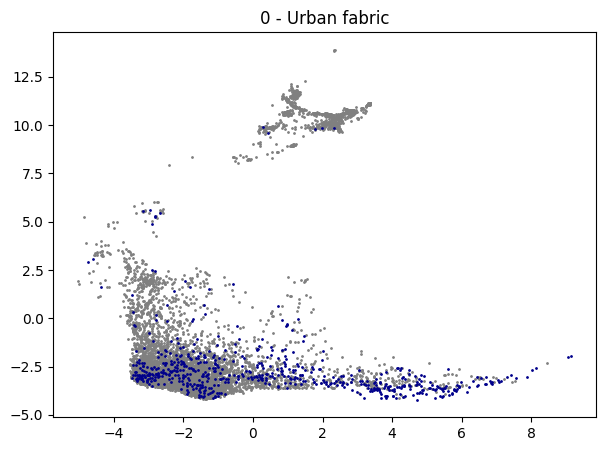

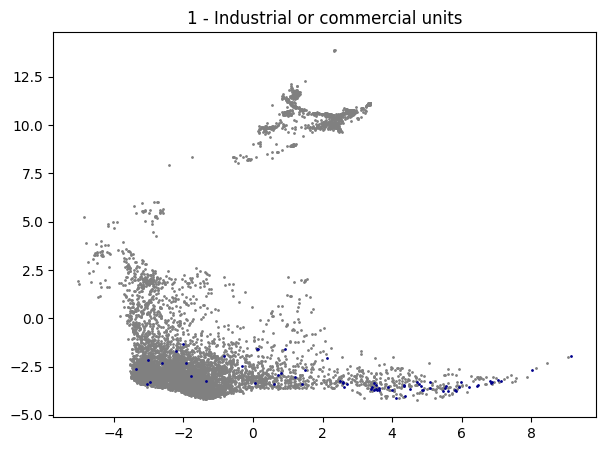

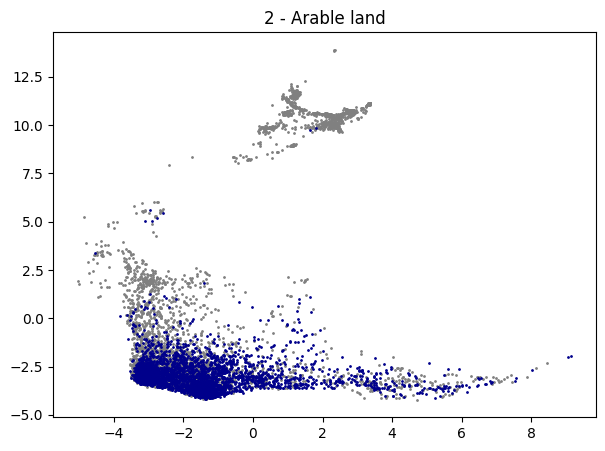

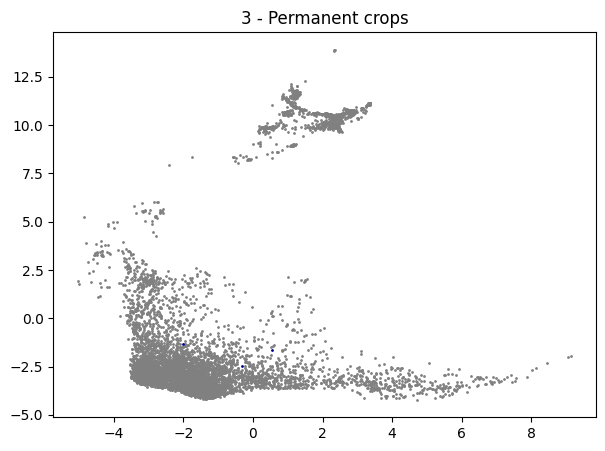

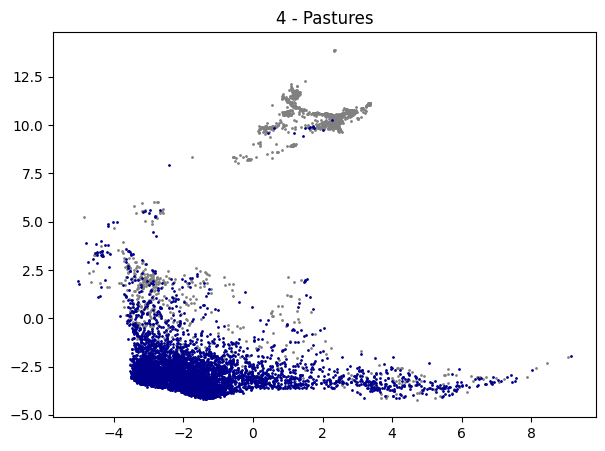

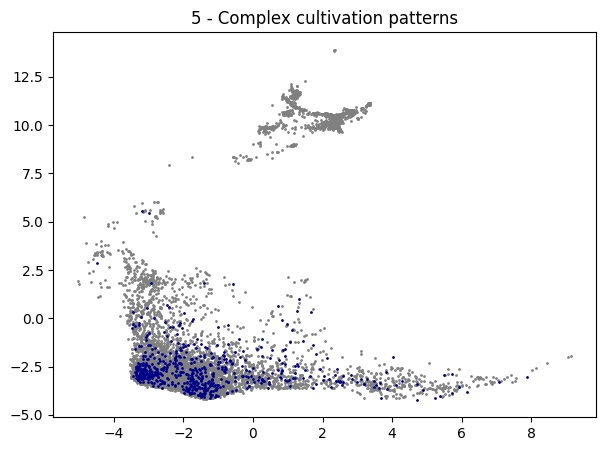

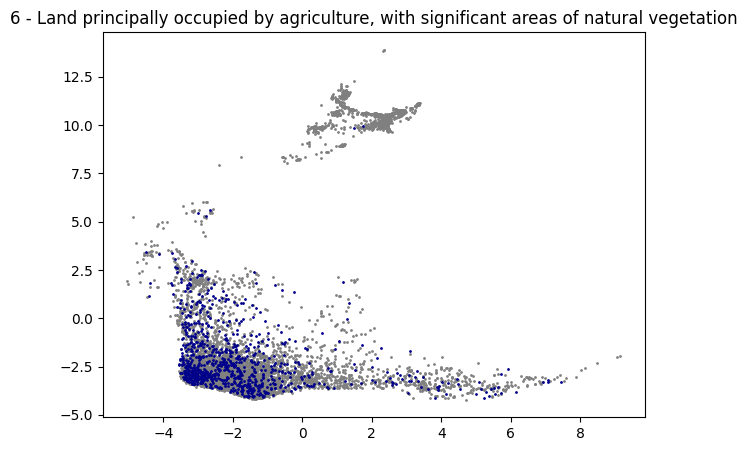

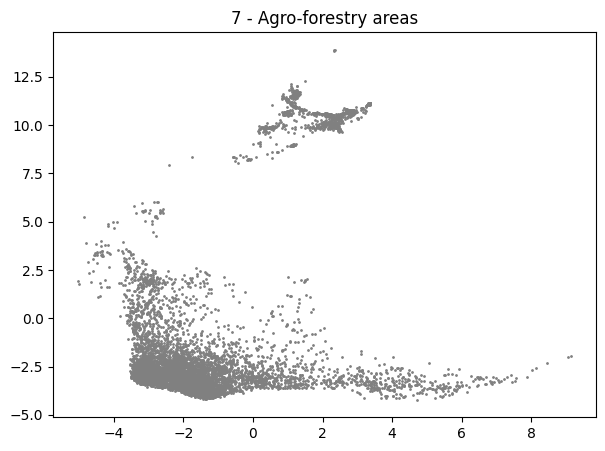

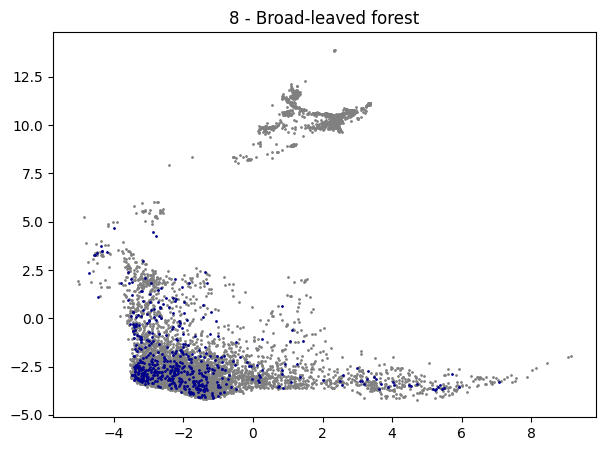

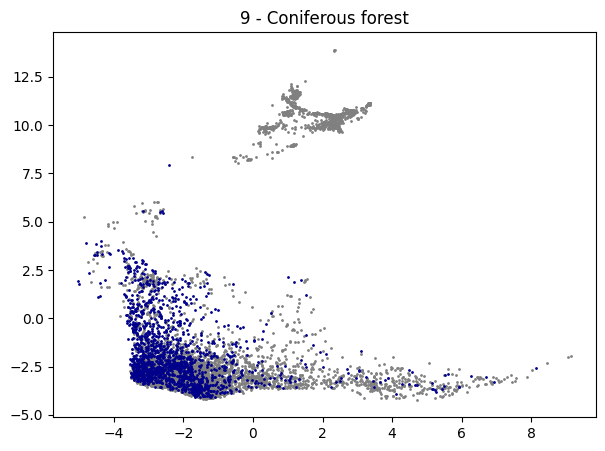

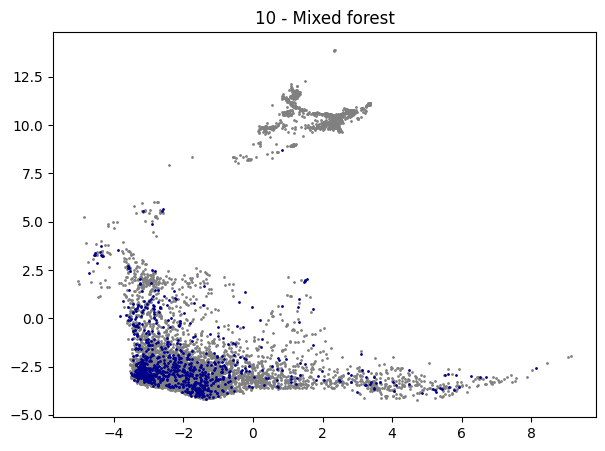

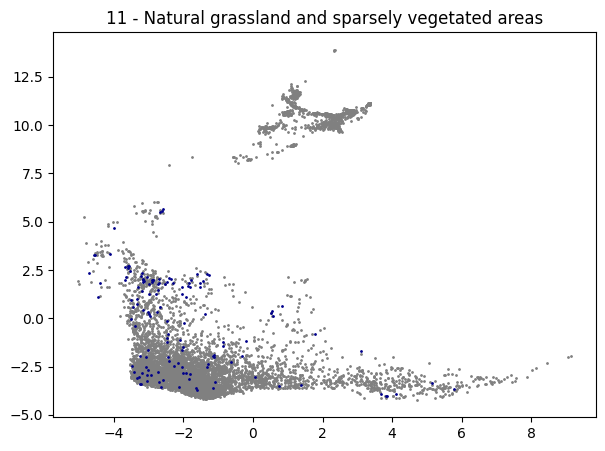

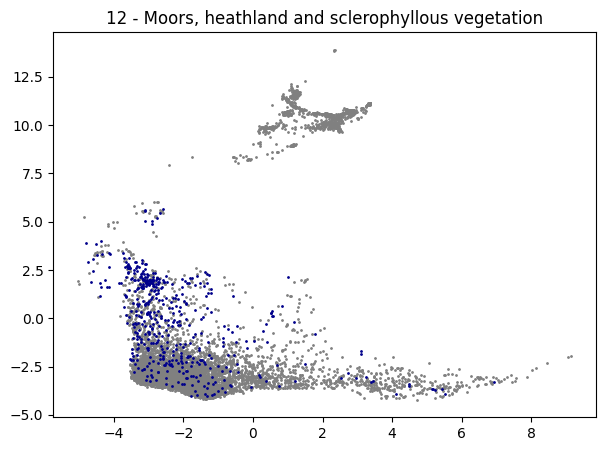

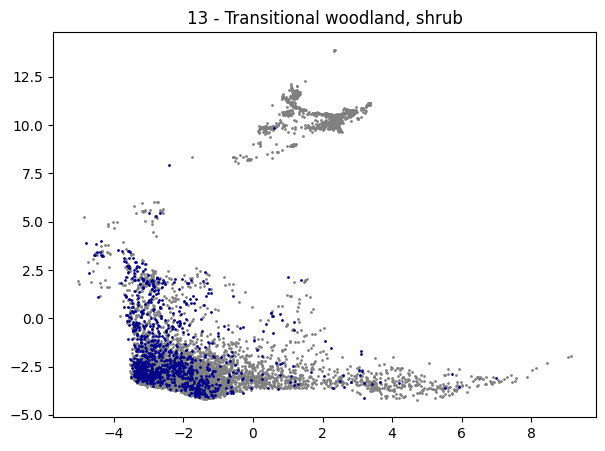

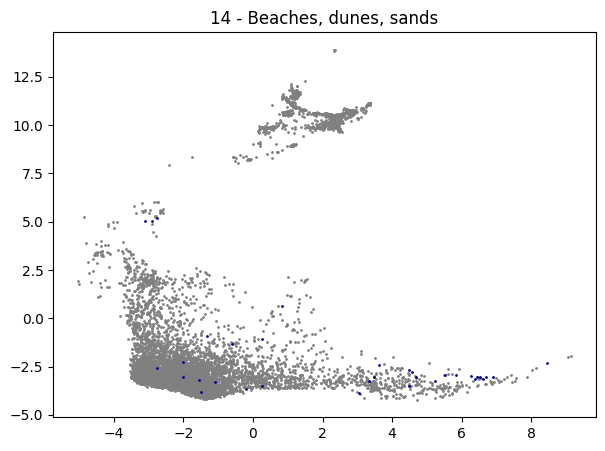

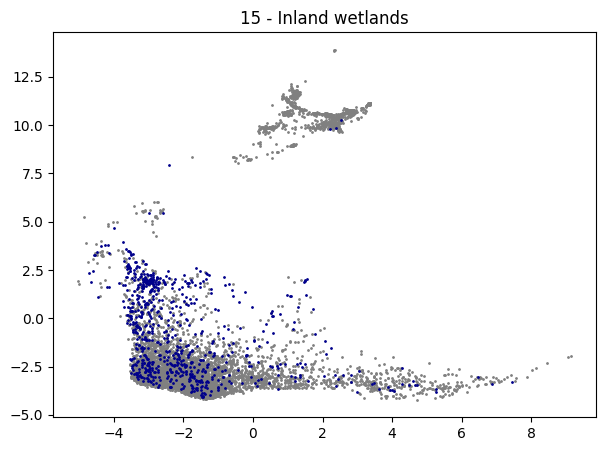

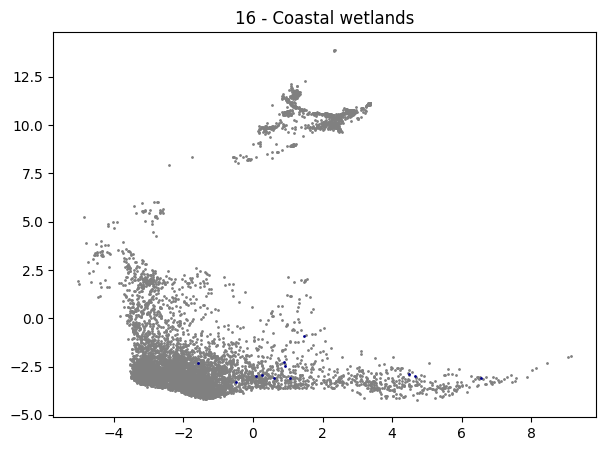

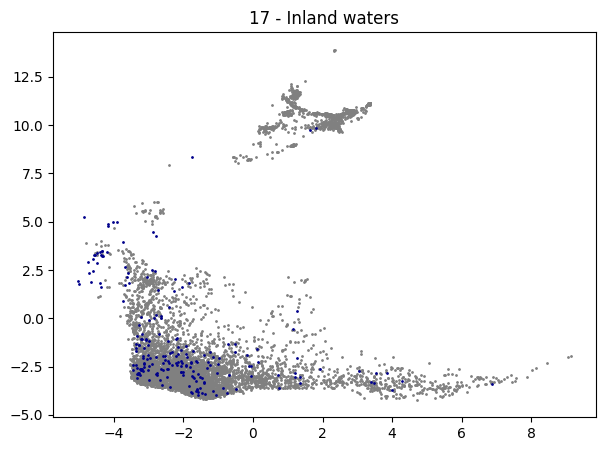

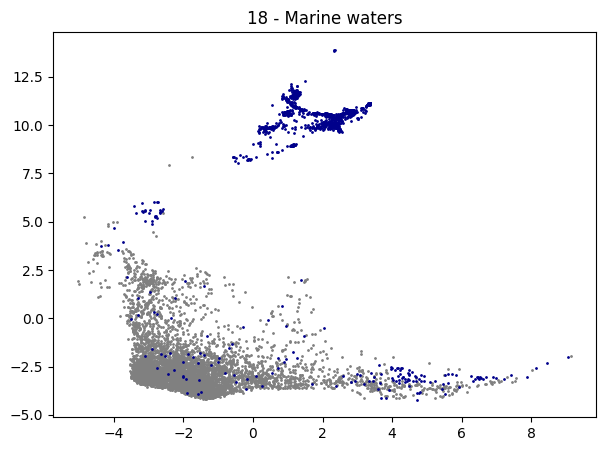

In [31]:
label_names = ["0 - Urban fabric",
        "1 - Industrial or commercial units",
        "2 - Arable land",
        "3 - Permanent crops",
        "4 - Pastures",
        "5 - Complex cultivation patterns",
        "6 - Land principally occupied by agriculture, with significant areas of natural vegetation",
        "7 - Agro-forestry areas",
        "8 - Broad-leaved forest",
        "9 - Coniferous forest",
        "10 - Mixed forest",
        "11 - Natural grassland and sparsely vegetated areas",
        "12 - Moors, heathland and sclerophyllous vegetation",
        "13 - Transitional woodland, shrub",
        "14 - Beaches, dunes, sands",
        "15 - Inland wetlands",
        "16 - Coastal wetlands",
        "17 - Inland waters",
        "18 - Marine waters"
]

for class_ind in range(len(label_names)):
  positive = [[], []]
  negative = [[], []]

  for x, y in zip(X_umap[:8000], data["labels"][:8000]):
    if round(y[class_ind]):
      positive[0].append(x[0])
      positive[1].append(x[1])
    else:
      negative[0].append(x[0])
      negative[1].append(x[1])

  plt.figure(figsize=(7, 5))
  plt.scatter(negative[0], negative[1], c="gray", s=1)
  plt.scatter(positive[0], positive[1], c="darkblue", s=1)
  plt.title(label_names[class_ind])
  plt.savefig("drive/MyDrive/reevaluation-geography-aware-ssl/code/extractedFeatures/" + model_name + "/umap/" + label_names[class_ind] + ".pdf")
  plt.show()

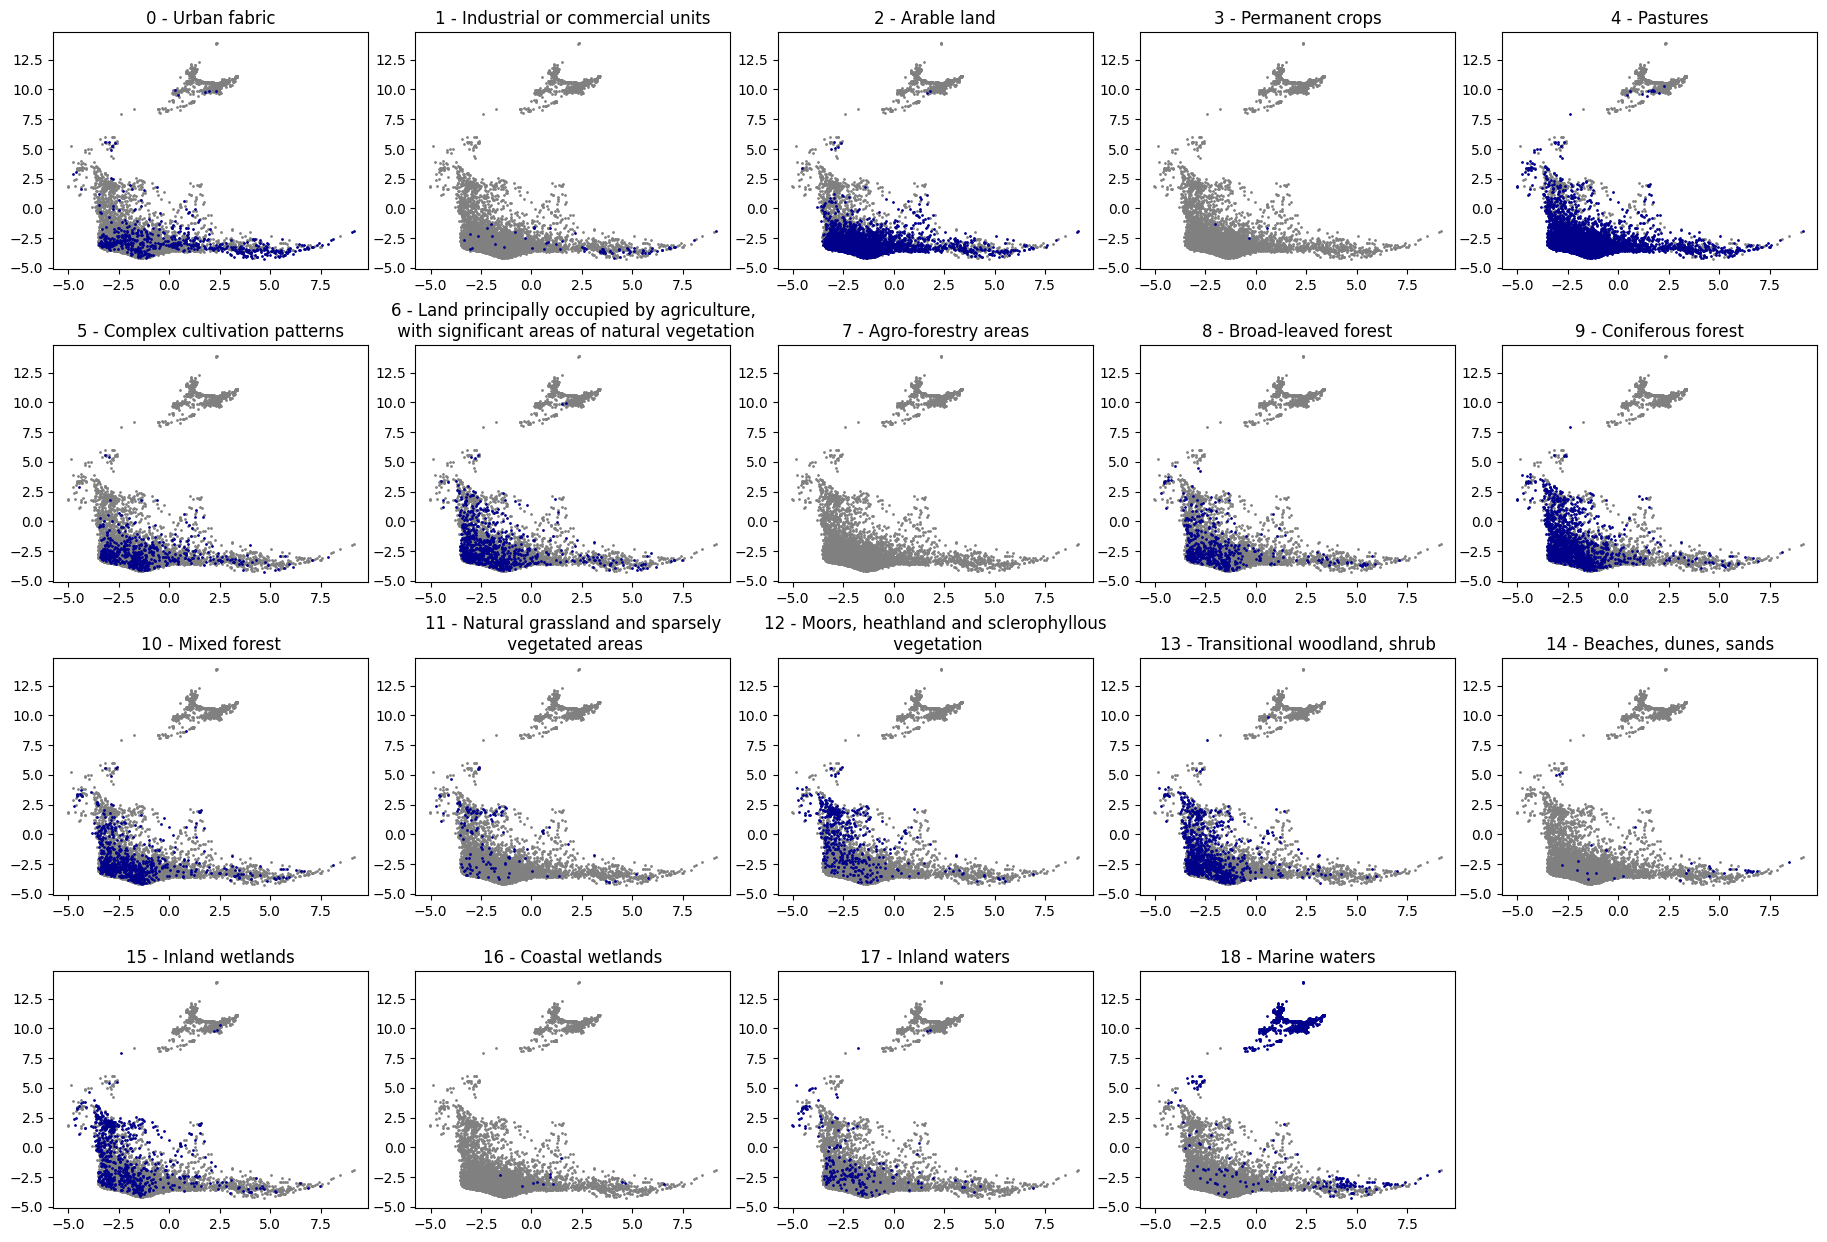

In [32]:
plt.figure(figsize=(18, 12))
for class_ind in range(len(label_names)):
  positive = [[], []]
  negative = [[], []]

  for x, y in zip(X_umap[:8000], data["labels"][:8000]):
    if round(y[class_ind]):
      positive[0].append(x[0])
      positive[1].append(x[1])
    else:
      negative[0].append(x[0])
      negative[1].append(x[1])

  plt.subplot(4, 5, class_ind+1)
  plt.scatter(negative[0], negative[1], c="gray", s=1)
  plt.scatter(positive[0], positive[1], c="darkblue", s=1)
  if class_ind == 6:
    plt.title("6 - Land principally occupied by agriculture,\n with significant areas of natural vegetation")
  elif class_ind == 11:
    plt.title("11 - Natural grassland and sparsely\n vegetated areas")
  elif class_ind == 12:
    plt.title("12 - Moors, heathland and sclerophyllous\n vegetation")
  else:
    plt.title(label_names[class_ind])

plt.subplots_adjust(left=0.01, bottom=0.01, right=0.99, top=0.99, wspace=0.15, hspace=0.32)
plt.savefig("drive/MyDrive/reevaluation-geography-aware-ssl/code/extractedFeatures/" + model_name + "/umap/all_labels.pdf")
plt.show()

## DataLoaders

In [27]:
from torch.utils.data import Dataset, DataLoader

path = "drive/MyDrive/reevaluation-geography-aware-ssl/code/extractedFeatures/" + model_name

with open(path + "/train.json", 'r') as file:
  data_train = json.load(file)

with open(path + "/val.json", 'r') as file:
  data_val= json.load(file)

with open(path + "/test.json", 'r') as file:
  data_test = json.load(file)

In [28]:
class FeatureDataset(Dataset):
  def __init__(self, inputs, labels):
    self.inputs = torch.Tensor(inputs)
    self.labels = torch.Tensor(labels)

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, idx):
    input = self.inputs[idx]
    label = self.labels[idx]
    return input, label

#print("train")
#print(data_train["feature_vectors"][:5])
#print(data_train["labels"][:5])#

#print("val")
#print(data_val["feature_vectors"][:5])
#print(data_val["labels"][:5])

#print("test")
#print(data_test["feature_vectors"][:5])
#print(data_test["labels"][:5])

train_dataset = FeatureDataset(data_train["feature_vectors"], data_train["labels"])
val_dataset = FeatureDataset(data_val["feature_vectors"], data_val["labels"])
test_dataset = FeatureDataset(data_test["feature_vectors"], data_test["labels"])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [4]:
#!pip install torchinfo
from torchinfo import summary
import torch.nn as nn

def one_error(ground_truth, predictions):

    top_predicted_labels = np.argmax(predictions, axis=1)

    incorrect_predictions = 0
    for i in range(len(predictions)):
        if ground_truth[i, top_predicted_labels[i]] == 0:
            incorrect_predictions += 1

    one_error_rate = incorrect_predictions / len(predictions)

    return one_error_rate


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(128, 384),
            nn.ReLU(),
            nn.Linear(384, 192),
            nn.ReLU(),
            nn.Linear(192, 100),
            nn.ReLU(),
            nn.Linear(100, 19)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP()
summary(model, input_size=(1, 128))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 19]                   --
├─Sequential: 1-1                        [1, 19]                   --
│    └─Linear: 2-1                       [1, 384]                  49,536
│    └─ReLU: 2-2                         [1, 384]                  --
│    └─Linear: 2-3                       [1, 192]                  73,920
│    └─ReLU: 2-4                         [1, 192]                  --
│    └─Linear: 2-5                       [1, 100]                  19,300
│    └─ReLU: 2-6                         [1, 100]                  --
│    └─Linear: 2-7                       [1, 19]                   1,919
Total params: 144,675
Trainable params: 144,675
Non-trainable params: 0
Total mult-adds (M): 0.14
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.58
Estimated Total Size (MB): 0.58

## Linear Probing Training

In [ ]:
import torch.optim as optim
from sklearn.metrics import recall_score, fbeta_score, hamming_loss
import numpy as np
import torch.nn as nn
from tqdm import tqdm

path_training = "drive/MyDrive/reevaluation-geography-aware-ssl/code/training/" + model_name

learning_rate = 0.01
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Linear(128, 19)
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

best_val_loss = 1000
history = {'train_loss': [], 'train_recall': [], 'train_f2_macro': [],
           'train_f2_micro': [], 'train_hl': [], 'train_oe': [],
           'val_loss': [], 'val_recall': [], 'val_f2_macro': [],
           'val_f2_micro': [], 'val_hl': [], 'val_oe': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    train_outputs = []
    train_labels = []

    for batch_inputs, batch_labels in tqdm(train_dataloader):
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_outputs.append(outputs.cpu().detach().numpy())
        train_labels.append(batch_labels.cpu().detach().numpy())

    train_outputs = np.concatenate(train_outputs, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    train_outputs_binary = (train_outputs >= 0.5).astype(int)

    average_train_loss = np.mean(train_loss)
    average_train_recall = recall_score(train_labels, train_outputs_binary, average='macro', zero_division=1)
    average_train_f2_macro = fbeta_score(train_labels, train_outputs_binary, average='macro', zero_division=1, beta=2) # macro -> giving equal importance to each class
    average_train_f2_micro = fbeta_score(train_labels, train_outputs_binary, average='micro', zero_division=1, beta=2)
    average_train_hl = hamming_loss(train_labels, train_outputs_binary)
    average_train_oe = one_error(train_labels, train_outputs_binary)

    model.eval()
    val_loss = []
    val_outputs = []
    val_labels = []

    with torch.no_grad():
        for batch_inputs, batch_labels in tqdm(val_dataloader):
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            val_loss.append(loss.item())
            val_outputs.append(outputs.cpu().detach().numpy())
            val_labels.append(batch_labels.cpu().detach().numpy())

    val_outputs = np.concatenate(val_outputs, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    val_outputs_binary = (val_outputs >= 0.5).astype(int)

    average_val_loss = np.mean(val_loss)
    average_val_recall = recall_score(val_labels, val_outputs_binary, average='macro', zero_division=1)
    average_val_f2_macro = fbeta_score(val_labels, val_outputs_binary, average='macro', zero_division=1, beta=2)
    average_val_f2_micro = fbeta_score(val_labels, val_outputs_binary, average='micro', zero_division=1, beta=2)
    average_val_hl = hamming_loss(val_labels, val_outputs_binary)
    average_val_oe = one_error(val_labels, val_outputs_binary)

    history['train_loss'].append(average_train_loss)
    history['train_recall'].append(average_train_recall)
    history['train_f2_macro'].append(average_train_f2_macro)
    history['train_f2_micro'].append(average_train_f2_micro)
    history['train_hl'].append(average_train_hl)
    history['train_oe'].append(average_train_oe)
    history['val_loss'].append(average_val_loss)
    history['val_recall'].append(average_val_recall)
    history['val_f2_macro'].append(average_val_f2_macro)
    history['val_f2_micro'].append(average_val_f2_micro)
    history['val_hl'].append(average_val_hl)
    history['val_oe'].append(average_val_oe)

    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        torch.save(model.state_dict(), path_training + '/linear_probing.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    print(f'Train Recall: {average_train_recall:.4f}, Val Recall: {average_val_recall:.4f}')
    print(f'Train F2 macro: {average_train_f2_macro:.4f}, Val F2 macro: {average_val_f2_macro:.4f}, Train F2 micro: {average_train_f2_micro:.4f}, Val F2 micro: {average_val_f2_micro:.4f}')
    print(f'Train hl: {average_train_hl:.4f}, Val hl: {average_val_hl:.4f}, Train oe: {average_train_oe:.4f}, Val oe: {average_val_oe:.4f}')

    with open(path_training + '/training_history_linear_probing.json', 'w') as f:
        json.dump(history, f)

    #scheduler.step()

100%|██████████| 7733/7733 [00:03<00:00, 2010.11it/s]


Epoch [1/20], Train Loss: 0.2771, Val Loss: 0.2651
Train Recall: 0.1691, Val Recall: 0.1949
Train F2 macro: 0.1879, Val F2 macro: 0.2144, Train F2 micro: 0.2869, Val F2 micro: 0.3217
Train hl: 0.1251, Val hl: 0.1206, Train oe: 0.8324, Val oe: 0.8179


100%|██████████| 7733/7733 [00:04<00:00, 1609.61it/s]


Epoch [2/20], Train Loss: 0.2690, Val Loss: 0.2641
Train Recall: 0.2031, Val Recall: 0.2085
Train F2 macro: 0.2245, Val F2 macro: 0.2291, Train F2 micro: 0.3289, Val F2 micro: 0.3349
Train hl: 0.1213, Val hl: 0.1199, Train oe: 0.8218, Val oe: 0.8149


100%|██████████| 7733/7733 [00:04<00:00, 1785.66it/s]


Epoch [3/20], Train Loss: 0.2684, Val Loss: 0.2629
Train Recall: 0.2091, Val Recall: 0.2117
Train F2 macro: 0.2310, Val F2 macro: 0.2324, Train F2 micro: 0.3348, Val F2 micro: 0.3459
Train hl: 0.1207, Val hl: 0.1189, Train oe: 0.8208, Val oe: 0.8131


100%|██████████| 7733/7733 [00:03<00:00, 1966.74it/s]


Epoch [4/20], Train Loss: 0.2683, Val Loss: 0.2629
Train Recall: 0.2108, Val Recall: 0.2100
Train F2 macro: 0.2329, Val F2 macro: 0.2309, Train F2 micro: 0.3369, Val F2 micro: 0.3344
Train hl: 0.1205, Val hl: 0.1193, Train oe: 0.8211, Val oe: 0.8157


100%|██████████| 7733/7733 [00:03<00:00, 1972.04it/s]


Epoch [5/20], Train Loss: 0.2682, Val Loss: 0.2627
Train Recall: 0.2125, Val Recall: 0.1964
Train F2 macro: 0.2347, Val F2 macro: 0.2699, Train F2 micro: 0.3383, Val F2 micro: 0.3222
Train hl: 0.1204, Val hl: 0.1203, Train oe: 0.8208, Val oe: 0.8186


100%|██████████| 7733/7733 [00:04<00:00, 1547.33it/s]


Epoch [6/20], Train Loss: 0.2682, Val Loss: 0.2631
Train Recall: 0.2130, Val Recall: 0.2153
Train F2 macro: 0.2353, Val F2 macro: 0.2360, Train F2 micro: 0.3381, Val F2 micro: 0.3439
Train hl: 0.1205, Val hl: 0.1193, Train oe: 0.8208, Val oe: 0.8150


100%|██████████| 7733/7733 [00:04<00:00, 1925.41it/s]


Epoch [7/20], Train Loss: 0.2681, Val Loss: 0.2637
Train Recall: 0.2137, Val Recall: 0.2017
Train F2 macro: 0.2360, Val F2 macro: 0.2755, Train F2 micro: 0.3386, Val F2 micro: 0.3270
Train hl: 0.1204, Val hl: 0.1204, Train oe: 0.8210, Val oe: 0.8170


100%|██████████| 7733/7733 [00:04<00:00, 1585.60it/s]


Epoch [8/20], Train Loss: 0.2681, Val Loss: 0.2624
Train Recall: 0.2134, Val Recall: 0.2125
Train F2 macro: 0.2357, Val F2 macro: 0.2868, Train F2 micro: 0.3384, Val F2 micro: 0.3412
Train hl: 0.1205, Val hl: 0.1191, Train oe: 0.8208, Val oe: 0.8155


100%|██████████| 7733/7733 [00:04<00:00, 1619.93it/s]


Epoch [9/20], Train Loss: 0.2681, Val Loss: 0.2638
Train Recall: 0.2140, Val Recall: 0.2055
Train F2 macro: 0.2363, Val F2 macro: 0.2783, Train F2 micro: 0.3391, Val F2 micro: 0.3329
Train hl: 0.1204, Val hl: 0.1202, Train oe: 0.8205, Val oe: 0.8175


100%|██████████| 7733/7733 [00:04<00:00, 1919.74it/s]


Epoch [10/20], Train Loss: 0.2681, Val Loss: 0.2625
Train Recall: 0.2134, Val Recall: 0.2146
Train F2 macro: 0.2357, Val F2 macro: 0.2886, Train F2 micro: 0.3385, Val F2 micro: 0.3409
Train hl: 0.1204, Val hl: 0.1191, Train oe: 0.8207, Val oe: 0.8148


100%|██████████| 7733/7733 [00:03<00:00, 1968.99it/s]


Epoch [11/20], Train Loss: 0.2681, Val Loss: 0.2633
Train Recall: 0.2140, Val Recall: 0.2137
Train F2 macro: 0.2364, Val F2 macro: 0.2872, Train F2 micro: 0.3393, Val F2 micro: 0.3381
Train hl: 0.1204, Val hl: 0.1197, Train oe: 0.8206, Val oe: 0.8164


100%|██████████| 7733/7733 [00:04<00:00, 1646.48it/s]


Epoch [12/20], Train Loss: 0.2681, Val Loss: 0.2632
Train Recall: 0.2145, Val Recall: 0.2110
Train F2 macro: 0.2369, Val F2 macro: 0.2833, Train F2 micro: 0.3392, Val F2 micro: 0.3381
Train hl: 0.1204, Val hl: 0.1192, Train oe: 0.8208, Val oe: 0.8151


100%|██████████| 7733/7733 [00:04<00:00, 1912.11it/s]


Epoch [13/20], Train Loss: 0.2681, Val Loss: 0.2629
Train Recall: 0.2141, Val Recall: 0.2100
Train F2 macro: 0.2364, Val F2 macro: 0.2837, Train F2 micro: 0.3389, Val F2 micro: 0.3375
Train hl: 0.1205, Val hl: 0.1193, Train oe: 0.8206, Val oe: 0.8150


100%|██████████| 7733/7733 [00:03<00:00, 1951.15it/s]


Epoch [14/20], Train Loss: 0.2681, Val Loss: 0.2630
Train Recall: 0.2140, Val Recall: 0.2187
Train F2 macro: 0.2364, Val F2 macro: 0.2919, Train F2 micro: 0.3392, Val F2 micro: 0.3589
Train hl: 0.1204, Val hl: 0.1183, Train oe: 0.8206, Val oe: 0.8117


100%|██████████| 7733/7733 [00:04<00:00, 1645.15it/s]


Epoch [15/20], Train Loss: 0.2681, Val Loss: 0.2633
Train Recall: 0.2143, Val Recall: 0.2058
Train F2 macro: 0.2367, Val F2 macro: 0.2254, Train F2 micro: 0.3390, Val F2 micro: 0.3328
Train hl: 0.1204, Val hl: 0.1193, Train oe: 0.8207, Val oe: 0.8152


100%|██████████| 7733/7733 [00:05<00:00, 1454.72it/s]


Epoch [16/20], Train Loss: 0.2681, Val Loss: 0.2627
Train Recall: 0.2144, Val Recall: 0.2145
Train F2 macro: 0.2368, Val F2 macro: 0.2876, Train F2 micro: 0.3391, Val F2 micro: 0.3387
Train hl: 0.1204, Val hl: 0.1196, Train oe: 0.8207, Val oe: 0.8163


100%|██████████| 7733/7733 [00:04<00:00, 1917.53it/s]


Epoch [17/20], Train Loss: 0.2681, Val Loss: 0.2621
Train Recall: 0.2144, Val Recall: 0.2138
Train F2 macro: 0.2368, Val F2 macro: 0.2879, Train F2 micro: 0.3390, Val F2 micro: 0.3479
Train hl: 0.1204, Val hl: 0.1185, Train oe: 0.8207, Val oe: 0.8140


100%|██████████| 7733/7733 [00:04<00:00, 1914.98it/s]


Epoch [18/20], Train Loss: 0.2681, Val Loss: 0.2631
Train Recall: 0.2147, Val Recall: 0.2096
Train F2 macro: 0.2371, Val F2 macro: 0.2830, Train F2 micro: 0.3391, Val F2 micro: 0.3409
Train hl: 0.1204, Val hl: 0.1189, Train oe: 0.8204, Val oe: 0.8140


100%|██████████| 7733/7733 [00:04<00:00, 1578.26it/s]


Epoch [19/20], Train Loss: 0.2681, Val Loss: 0.2631
Train Recall: 0.2148, Val Recall: 0.2183
Train F2 macro: 0.2372, Val F2 macro: 0.2908, Train F2 micro: 0.3389, Val F2 micro: 0.3467
Train hl: 0.1204, Val hl: 0.1190, Train oe: 0.8207, Val oe: 0.8149


100%|██████████| 7733/7733 [00:03<00:00, 1944.03it/s]


Epoch [20/20], Train Loss: 0.2681, Val Loss: 0.2636
Train Recall: 0.2146, Val Recall: 0.2255
Train F2 macro: 0.2371, Val F2 macro: 0.2995, Train F2 micro: 0.3391, Val F2 micro: 0.3626
Train hl: 0.1204, Val hl: 0.1180, Train oe: 0.8205, Val oe: 0.8135


## MLP

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.metrics import recall_score, fbeta_score, hamming_loss
from tqdm import tqdm
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_training = "drive/MyDrive/reevaluation-geography-aware-ssl/code/training/" + model_name

model = MLP().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True)

history = {
    'train_loss': [], 'train_recall': [], 'train_f2_macro': [],
    'train_f2_micro': [], 'train_hl': [], 'train_oe': [],
    'val_loss': [], 'val_recall': [], 'val_f2_macro': [],
    'val_f2_micro': [], 'val_hl': [], 'val_oe': []
}

num_epochs = 30
best_val_f2_macro = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = []
    train_outputs = []
    train_labels = []

    for batch_inputs, batch_labels in tqdm(train_dataloader):
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
        train_outputs.append(outputs.cpu().detach().numpy())
        train_labels.append(batch_labels.cpu().detach().numpy())

    train_outputs = np.concatenate(train_outputs, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)
    train_outputs_binary = (train_outputs >= 0.5).astype(int)

    average_train_loss = np.mean(train_loss)
    average_train_recall = recall_score(train_labels, train_outputs_binary, average='macro', zero_division=1)
    average_train_f2_macro = fbeta_score(train_labels, train_outputs_binary, average='macro', zero_division=1, beta=2)
    average_train_f2_micro = fbeta_score(train_labels, train_outputs_binary, average='micro', zero_division=1, beta=2)
    average_train_hl = hamming_loss(train_labels, train_outputs_binary)
    average_train_oe = one_error(train_labels, train_outputs_binary)

    model.eval()
    val_loss = []
    val_outputs = []
    val_labels = []

    with torch.no_grad():
        for batch_inputs, batch_labels in tqdm(val_dataloader):
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)

            val_loss.append(loss.item())
            val_outputs.append(outputs.cpu().detach().numpy())
            val_labels.append(batch_labels.cpu().detach().numpy())

    val_outputs = np.concatenate(val_outputs, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    val_outputs_binary = (val_outputs >= 0.5).astype(int)

    average_val_loss = np.mean(val_loss)
    average_val_recall = recall_score(val_labels, val_outputs_binary, average='macro', zero_division=1)
    average_val_f2_macro = fbeta_score(val_labels, val_outputs_binary, average='macro', zero_division=1, beta=2)
    average_val_f2_micro = fbeta_score(val_labels, val_outputs_binary, average='micro', zero_division=1, beta=2)
    average_val_hl = hamming_loss(val_labels, val_outputs_binary)
    average_val_oe = one_error(val_labels, val_outputs_binary)

    history['train_loss'].append(average_train_loss)
    history['train_recall'].append(average_train_recall)
    history['train_f2_macro'].append(average_train_f2_macro)
    history['train_f2_micro'].append(average_train_f2_micro)
    history['train_hl'].append(average_train_hl)
    history['train_oe'].append(average_train_oe)
    history['val_loss'].append(average_val_loss)
    history['val_recall'].append(average_val_recall)
    history['val_f2_macro'].append(average_val_f2_macro)
    history['val_f2_micro'].append(average_val_f2_micro)
    history['val_hl'].append(average_val_hl)
    history['val_oe'].append(average_val_oe)

    if average_val_f2_macro > best_val_f2_macro:
        best_val_f2_macro = average_val_f2_macro
        torch.save(model.state_dict(), path_training + '/mlp_regularization.pth')

    scheduler.step(average_val_loss)  # Step the scheduler

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}')
    print(f'Train Recall: {average_train_recall:.4f}, Val Recall: {average_val_recall:.4f}')
    print(f'Train F2 macro: {average_train_f2_macro:.4f}, Val F2 macro: {average_val_f2_macro:.4f}, Train F2 micro: {average_train_f2_micro:.4f}, Val F2 micro: {average_val_f2_micro:.4f}')
    print(f'Train hl: {average_train_hl:.4f}, Val hl: {average_val_hl:.4f}, Train oe: {average_train_oe:.4f}, Val oe: {average_val_oe:.4f}')

    with open(path_training + '/training_history_mlp_regularization.json', 'w') as f:
        json.dump(history, f)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 7733/7733 [00:04<00:00, 1797.73it/s]


Epoch [1/30], Train Loss: 0.2479, Val Loss: 0.2274
Train Recall: 0.2210, Val Recall: 0.2869
Train F2 macro: 0.2428, Val F2 macro: 0.3130, Train F2 micro: 0.3868, Val F2 micro: 0.4656
Train hl: 0.1125, Val hl: 0.1029, Train oe: 0.8044, Val oe: 0.7734


100%|██████████| 7733/7733 [00:07<00:00, 1101.74it/s]


Epoch [2/30], Train Loss: 0.2257, Val Loss: 0.2187
Train Recall: 0.2947, Val Recall: 0.2988
Train F2 macro: 0.3224, Val F2 macro: 0.3264, Train F2 micro: 0.4653, Val F2 micro: 0.4679
Train hl: 0.1024, Val hl: 0.1006, Train oe: 0.7774, Val oe: 0.7687


100%|██████████| 7733/7733 [00:05<00:00, 1414.23it/s]


Epoch [3/30], Train Loss: 0.2192, Val Loss: 0.2168
Train Recall: 0.3191, Val Recall: 0.3315
Train F2 macro: 0.3488, Val F2 macro: 0.3586, Train F2 micro: 0.4874, Val F2 micro: 0.4857
Train hl: 0.0994, Val hl: 0.0991, Train oe: 0.7693, Val oe: 0.7675


100%|██████████| 7733/7733 [00:06<00:00, 1109.03it/s]


Epoch [4/30], Train Loss: 0.2153, Val Loss: 0.2137
Train Recall: 0.3331, Val Recall: 0.3382
Train F2 macro: 0.3637, Val F2 macro: 0.3680, Train F2 micro: 0.5004, Val F2 micro: 0.5027
Train hl: 0.0975, Val hl: 0.0971, Train oe: 0.7630, Val oe: 0.7561


100%|██████████| 7733/7733 [00:04<00:00, 1782.40it/s]


Epoch [5/30], Train Loss: 0.2125, Val Loss: 0.2112
Train Recall: 0.3434, Val Recall: 0.3502
Train F2 macro: 0.3748, Val F2 macro: 0.3793, Train F2 micro: 0.5090, Val F2 micro: 0.5256
Train hl: 0.0963, Val hl: 0.0952, Train oe: 0.7598, Val oe: 0.7487


100%|██████████| 7733/7733 [00:04<00:00, 1776.56it/s]


Epoch [6/30], Train Loss: 0.2104, Val Loss: 0.2146
Train Recall: 0.3507, Val Recall: 0.3437
Train F2 macro: 0.3825, Val F2 macro: 0.3733, Train F2 micro: 0.5154, Val F2 micro: 0.5069
Train hl: 0.0954, Val hl: 0.0970, Train oe: 0.7571, Val oe: 0.7591


100%|██████████| 7733/7733 [00:04<00:00, 1767.99it/s]


Epoch [7/30], Train Loss: 0.2086, Val Loss: 0.2111
Train Recall: 0.3571, Val Recall: 0.3532
Train F2 macro: 0.3893, Val F2 macro: 0.3825, Train F2 micro: 0.5208, Val F2 micro: 0.5273
Train hl: 0.0945, Val hl: 0.0949, Train oe: 0.7551, Val oe: 0.7524


100%|██████████| 7733/7733 [00:04<00:00, 1755.71it/s]


Epoch [8/30], Train Loss: 0.2072, Val Loss: 0.2103
Train Recall: 0.3626, Val Recall: 0.3436
Train F2 macro: 0.3952, Val F2 macro: 0.3754, Train F2 micro: 0.5252, Val F2 micro: 0.5118
Train hl: 0.0939, Val hl: 0.0956, Train oe: 0.7527, Val oe: 0.7546


100%|██████████| 7733/7733 [00:04<00:00, 1742.65it/s]


Epoch [9/30], Train Loss: 0.2058, Val Loss: 0.2110
Train Recall: 0.3677, Val Recall: 0.3618
Train F2 macro: 0.4007, Val F2 macro: 0.3925, Train F2 micro: 0.5289, Val F2 micro: 0.5163
Train hl: 0.0933, Val hl: 0.0954, Train oe: 0.7511, Val oe: 0.7525


100%|██████████| 7733/7733 [00:05<00:00, 1291.69it/s]


Epoch [10/30], Train Loss: 0.2047, Val Loss: 0.2112
Train Recall: 0.3731, Val Recall: 0.3566
Train F2 macro: 0.4064, Val F2 macro: 0.3889, Train F2 micro: 0.5328, Val F2 micro: 0.5129
Train hl: 0.0928, Val hl: 0.0953, Train oe: 0.7496, Val oe: 0.7517


100%|██████████| 7733/7733 [00:05<00:00, 1430.89it/s]


Epoch [11/30], Train Loss: 0.2038, Val Loss: 0.2104
Train Recall: 0.3762, Val Recall: 0.3675
Train F2 macro: 0.4097, Val F2 macro: 0.3990, Train F2 micro: 0.5355, Val F2 micro: 0.5257
Train hl: 0.0923, Val hl: 0.0946, Train oe: 0.7485, Val oe: 0.7457


100%|██████████| 7733/7733 [00:06<00:00, 1161.85it/s]


Epoch [12/30], Train Loss: 0.2029, Val Loss: 0.2109
Train Recall: 0.3802, Val Recall: 0.3735
Train F2 macro: 0.4140, Val F2 macro: 0.4021, Train F2 micro: 0.5379, Val F2 micro: 0.5276
Train hl: 0.0920, Val hl: 0.0948, Train oe: 0.7471, Val oe: 0.7488


100%|██████████| 7733/7733 [00:04<00:00, 1782.52it/s]


Epoch [13/30], Train Loss: 0.2021, Val Loss: 0.2107
Train Recall: 0.3838, Val Recall: 0.3659
Train F2 macro: 0.4178, Val F2 macro: 0.3955, Train F2 micro: 0.5401, Val F2 micro: 0.5207
Train hl: 0.0916, Val hl: 0.0951, Train oe: 0.7463, Val oe: 0.7521


100%|██████████| 7733/7733 [00:04<00:00, 1796.67it/s]


Epoch [14/30], Train Loss: 0.1955, Val Loss: 0.2083
Train Recall: 0.4025, Val Recall: 0.3850
Train F2 macro: 0.4376, Val F2 macro: 0.4155, Train F2 micro: 0.5549, Val F2 micro: 0.5392
Train hl: 0.0890, Val hl: 0.0932, Train oe: 0.7391, Val oe: 0.7432


100%|██████████| 7733/7733 [00:05<00:00, 1313.49it/s]


Epoch [15/30], Train Loss: 0.1944, Val Loss: 0.2087
Train Recall: 0.4074, Val Recall: 0.3803
Train F2 macro: 0.4428, Val F2 macro: 0.4105, Train F2 micro: 0.5590, Val F2 micro: 0.5415
Train hl: 0.0884, Val hl: 0.0930, Train oe: 0.7371, Val oe: 0.7429


100%|██████████| 7733/7733 [00:04<00:00, 1719.73it/s]


Epoch [16/30], Train Loss: 0.1939, Val Loss: 0.2087
Train Recall: 0.4098, Val Recall: 0.3884
Train F2 macro: 0.4453, Val F2 macro: 0.4190, Train F2 micro: 0.5603, Val F2 micro: 0.5440
Train hl: 0.0882, Val hl: 0.0928, Train oe: 0.7365, Val oe: 0.7437


100%|██████████| 7733/7733 [00:04<00:00, 1780.78it/s]


Epoch [17/30], Train Loss: 0.1934, Val Loss: 0.2089
Train Recall: 0.4120, Val Recall: 0.3912
Train F2 macro: 0.4476, Val F2 macro: 0.4221, Train F2 micro: 0.5618, Val F2 micro: 0.5470
Train hl: 0.0880, Val hl: 0.0928, Train oe: 0.7358, Val oe: 0.7426


100%|██████████| 7733/7733 [00:04<00:00, 1751.56it/s]


Epoch [18/30], Train Loss: 0.1931, Val Loss: 0.2091
Train Recall: 0.4142, Val Recall: 0.3903
Train F2 macro: 0.4499, Val F2 macro: 0.4206, Train F2 micro: 0.5631, Val F2 micro: 0.5444
Train hl: 0.0878, Val hl: 0.0930, Train oe: 0.7358, Val oe: 0.7429


100%|██████████| 7733/7733 [00:05<00:00, 1518.72it/s]


Epoch [19/30], Train Loss: 0.1927, Val Loss: 0.2093
Train Recall: 0.4151, Val Recall: 0.3918
Train F2 macro: 0.4509, Val F2 macro: 0.4214, Train F2 micro: 0.5641, Val F2 micro: 0.5458
Train hl: 0.0876, Val hl: 0.0929, Train oe: 0.7350, Val oe: 0.7424


100%|██████████| 7733/7733 [00:05<00:00, 1317.19it/s]


Epoch [20/30], Train Loss: 0.1910, Val Loss: 0.2091
Train Recall: 0.4201, Val Recall: 0.3916
Train F2 macro: 0.4563, Val F2 macro: 0.4216, Train F2 micro: 0.5674, Val F2 micro: 0.5451
Train hl: 0.0870, Val hl: 0.0928, Train oe: 0.7330, Val oe: 0.7425


100%|██████████| 7733/7733 [00:04<00:00, 1747.26it/s]


Epoch [21/30], Train Loss: 0.1908, Val Loss: 0.2093
Train Recall: 0.4204, Val Recall: 0.3923
Train F2 macro: 0.4566, Val F2 macro: 0.4225, Train F2 micro: 0.5679, Val F2 micro: 0.5456
Train hl: 0.0869, Val hl: 0.0928, Train oe: 0.7326, Val oe: 0.7417


100%|██████████| 7733/7733 [00:04<00:00, 1765.25it/s]


Epoch [22/30], Train Loss: 0.1907, Val Loss: 0.2093
Train Recall: 0.4220, Val Recall: 0.3921
Train F2 macro: 0.4582, Val F2 macro: 0.4224, Train F2 micro: 0.5688, Val F2 micro: 0.5461
Train hl: 0.0868, Val hl: 0.0928, Train oe: 0.7323, Val oe: 0.7419


100%|██████████| 7733/7733 [00:05<00:00, 1323.27it/s]


Epoch [23/30], Train Loss: 0.1906, Val Loss: 0.2095
Train Recall: 0.4220, Val Recall: 0.3924
Train F2 macro: 0.4582, Val F2 macro: 0.4224, Train F2 micro: 0.5691, Val F2 micro: 0.5466
Train hl: 0.0868, Val hl: 0.0928, Train oe: 0.7324, Val oe: 0.7423


100%|██████████| 7733/7733 [00:05<00:00, 1423.35it/s]


Epoch [24/30], Train Loss: 0.1905, Val Loss: 0.2095
Train Recall: 0.4227, Val Recall: 0.3936
Train F2 macro: 0.4589, Val F2 macro: 0.4238, Train F2 micro: 0.5692, Val F2 micro: 0.5487
Train hl: 0.0867, Val hl: 0.0927, Train oe: 0.7323, Val oe: 0.7416


100%|██████████| 7733/7733 [00:04<00:00, 1756.39it/s]


Epoch [25/30], Train Loss: 0.1901, Val Loss: 0.2095
Train Recall: 0.4233, Val Recall: 0.3942
Train F2 macro: 0.4596, Val F2 macro: 0.4245, Train F2 micro: 0.5705, Val F2 micro: 0.5473
Train hl: 0.0865, Val hl: 0.0928, Train oe: 0.7315, Val oe: 0.7419


100%|██████████| 7733/7733 [00:04<00:00, 1758.48it/s]


Epoch [26/30], Train Loss: 0.1900, Val Loss: 0.2095
Train Recall: 0.4242, Val Recall: 0.3933
Train F2 macro: 0.4606, Val F2 macro: 0.4236, Train F2 micro: 0.5706, Val F2 micro: 0.5467
Train hl: 0.0865, Val hl: 0.0928, Train oe: 0.7314, Val oe: 0.7420


100%|██████████| 7733/7733 [00:05<00:00, 1293.12it/s]


Epoch [27/30], Train Loss: 0.1900, Val Loss: 0.2095
Train Recall: 0.4237, Val Recall: 0.3936
Train F2 macro: 0.4601, Val F2 macro: 0.4238, Train F2 micro: 0.5703, Val F2 micro: 0.5471
Train hl: 0.0865, Val hl: 0.0928, Train oe: 0.7315, Val oe: 0.7419


100%|██████████| 7733/7733 [00:04<00:00, 1563.47it/s]


Epoch [28/30], Train Loss: 0.1900, Val Loss: 0.2095
Train Recall: 0.4244, Val Recall: 0.3939
Train F2 macro: 0.4608, Val F2 macro: 0.4241, Train F2 micro: 0.5705, Val F2 micro: 0.5475
Train hl: 0.0865, Val hl: 0.0928, Train oe: 0.7313, Val oe: 0.7420


100%|██████████| 7733/7733 [00:04<00:00, 1763.52it/s]


Epoch [29/30], Train Loss: 0.1900, Val Loss: 0.2095
Train Recall: 0.4238, Val Recall: 0.3938
Train F2 macro: 0.4602, Val F2 macro: 0.4240, Train F2 micro: 0.5705, Val F2 micro: 0.5474
Train hl: 0.0865, Val hl: 0.0928, Train oe: 0.7315, Val oe: 0.7420


100%|██████████| 7733/7733 [00:04<00:00, 1569.65it/s]


Epoch [30/30], Train Loss: 0.1899, Val Loss: 0.2095
Train Recall: 0.4243, Val Recall: 0.3939
Train F2 macro: 0.4606, Val F2 macro: 0.4241, Train F2 micro: 0.5708, Val F2 micro: 0.5472
Train hl: 0.0865, Val hl: 0.0928, Train oe: 0.7312, Val oe: 0.7420


## Learning curves and Evaluation

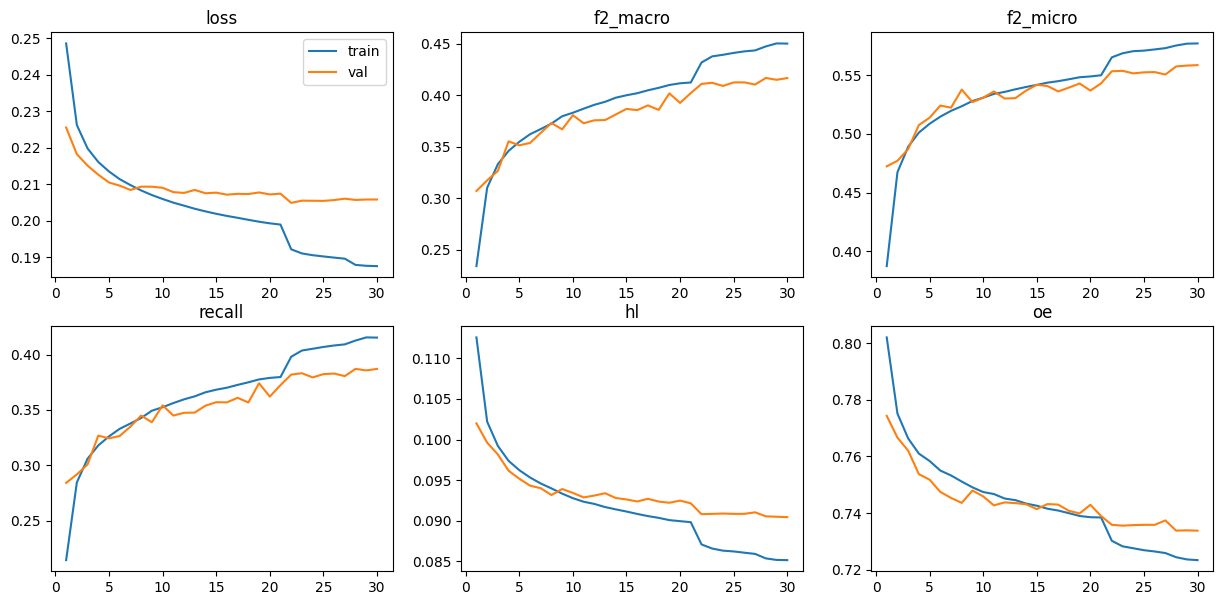

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np

path_to_json = "drive/MyDrive/reevaluation-geography-aware-ssl/code/training/" + model_name + "/training_history_mlp_regularization.json"

with open(path_to_json, 'r') as f:
    history = json.load(f)

def plot_metric(metric, first=False):
  data_train = history['train_' + metric]
  data_val = history['val_' + metric]
  x = np.linspace(1, 30, 30)
  plt.plot(x, data_train[:30], label="train")
  plt.plot(x, data_val[:30], label="val")
  plt.title(metric)
  if first:
    plt.legend()

plt.figure(figsize=(15, 7))
for i, metric in enumerate(["loss", "f2_macro", "f2_micro", "recall", "hl", "oe"]):
  plt.subplot(2, 3, i+1)
  plot_metric(metric, i==0)

plt.show()

In [30]:
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import recall_score, fbeta_score, hamming_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "drive/MyDrive/reevaluation-geography-aware-ssl/code/training/" + model_name + "/linear_probing.pth"
#model = MLP().to(device)
model = nn.Linear(128, 19).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

criterion = nn.BCEWithLogitsLoss()

loss_ = []
outputs_ = []
labels = []

with torch.no_grad():
    for batch_inputs, batch_labels in tqdm(test_dataloader):
        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)

        loss_.append(loss.item())
        outputs_.append(outputs.cpu().detach().numpy())
        labels.append(batch_labels.cpu().detach().numpy())

outputs = np.concatenate(outputs_, axis=0)
labels = np.concatenate(labels, axis=0)
outputs_binary = (outputs >= 0.5).astype(int)

average_loss = np.mean(loss_)
average_recall = recall_score(labels, outputs_binary, average='macro', zero_division=1)
average_f2_macro = fbeta_score(labels, outputs_binary, average='macro', zero_division=1, beta=2)
average_f2_micro = fbeta_score(labels, outputs_binary, average='micro', zero_division=1, beta=2)
average_hl = hamming_loss(labels, outputs_binary)
average_oe = one_error(labels, outputs_binary)

print(f'Loss: {average_loss:.4f}, Recall: {average_recall:.4f}')
print(f'F2 macro: {average_f2_macro:.4f}, F2 micro: {average_f2_micro:.4f}')
print(f'hl: {average_hl:.4f}, oe: {average_oe:.4f}')

100%|██████████| 7867/7867 [00:03<00:00, 2028.59it/s]


Loss: 0.2633, Recall: 0.2175
F2 macro: 0.2393, F2 micro: 0.3473
hl: 0.1188, oe: 0.3634


## Random Forest

In [ ]:
import numpy as np
import dask.array as da
from dask.distributed import Client, LocalCluster
from dask_ml.wrappers import ParallelPostFit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, fbeta_score, hamming_loss, zero_one_loss
import joblib
import json

cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit='2GB')
client = Client(cluster)

X_train = da.from_array(np.array(data_train["feature_vectors"]), chunks=(10000, -1)).rechunk((10000, -1))
y_train = da.from_array(np.array(data_train["labels"]), chunks=(10000, -1)).rechunk((10000, -1))
X_val = da.from_array(np.array(data_val["feature_vectors"]), chunks=(10000, -1)).rechunk((10000, -1))
y_val = da.from_array(np.array(data_val["labels"]), chunks=(10000, -1)).rechunk((10000, -1))
X_test = da.from_array(np.array(data_test["feature_vectors"]), chunks=(10000, -1)).rechunk((10000, -1))
y_test = da.from_array(np.array(data_test["labels"]), chunks=(10000, -1)).rechunk((10000, -1))

rf = RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features='sqrt',
    max_leaf_nodes=None,
    bootstrap=False
)
model = ParallelPostFit(estimator=rf)

model.fit(X_train, y_train)

path_training = "drive/MyDrive/reevaluation-geography-aware-ssl/code/training/" + model_name
joblib.dump(model, path_training + '/random_forest_model.pkl')

model_path = path_training + '/random_forest_model.pkl'
model = joblib.load(model_path)

X_train_np = X_train.compute()
X_val_np = X_val.compute()
X_test_np = X_test.compute()

y_train_pred = model.predict(X_train_np)
y_val_pred = model.predict(X_val_np)
y_test_pred = model.predict(X_test_np)

y_train_pred_bin = (y_train_pred > 0.5).astype(int)
y_val_pred_bin = (y_val_pred > 0.5).astype(int)
y_test_pred_bin = (y_test_pred > 0.5).astype(int)

y_train_np_actual = y_train.compute()
train_recall = recall_score(y_train_np_actual, y_train_pred_bin, average='macro', zero_division=1)
train_f2_micro = fbeta_score(y_train_np_actual, y_train_pred_bin, beta=2, average='micro')
train_f2_macro = fbeta_score(y_train_np_actual, y_train_pred_bin, beta=2, average='macro', zero_division=1)
train_hl = hamming_loss(y_train_np_actual, y_train_pred_bin)
train_oe = zero_one_loss(y_train_np_actual, y_train_pred_bin)

print(f'Train Recall: {train_recall:.4f}, Train F2 micro: {train_f2_micro:.4f}, Train F2 macro: {train_f2_macro:.4f}, Train HL: {train_hl:.4f}, Train OE: {train_oe:.4f}')

y_val_np_actual = y_val.compute()
val_recall = recall_score(y_val_np_actual, y_val_pred_bin, average='macro', zero_division=1)
val_f2_micro = fbeta_score(y_val_np_actual, y_val_pred_bin, beta=2, average='micro')
val_f2_macro = fbeta_score(y_val_np_actual, y_val_pred_bin, beta=2, average='macro', zero_division=1)
val_hl = hamming_loss(y_val_np_actual, y_val_pred_bin)
val_oe = zero_one_loss(y_val_np_actual, y_val_pred_bin)

print(f'Val Recall: {val_recall:.4f}, Val F2 micro: {val_f2_micro:.4f}, Val F2 macro: {val_f2_macro:.4f}, Val HL: {val_hl:.4f}, Val OE: {val_oe:.4f}')

y_test_np_actual = y_test.compute()
test_recall = recall_score(y_test_np_actual, y_test_pred_bin, average='macro', zero_division=1)
test_f2_micro = fbeta_score(y_test_np_actual, y_test_pred_bin, beta=2, average='micro')
test_f2_macro = fbeta_score(y_test_np_actual, y_test_pred_bin, beta=2, average='macro', zero_division=1)
test_hl = hamming_loss(y_test_np_actual, y_test_pred_bin)
test_oe = zero_one_loss(y_test_np_actual, y_test_pred_bin)

print(f'Test Recall: {test_recall:.4f}, Test F2 micro: {test_f2_micro:.4f}, Test F2 macro: {test_f2_macro:.4f}, Test HL: {test_hl:.4f}, Test OE: {test_oe:.4f}')

metrics = {
    'train': {
        'recall': train_recall,
        'f2_micro': train_f2_micro,
        'f2_macro': train_f2_macro,
        'hamming_loss': train_hl,
        'zero_one_loss': train_oe
    },
    'validation': {
        'recall': val_recall,
        'f2_micro': val_f2_micro,
        'f2_macro': val_f2_macro,
        'hamming_loss': val_hl,
        'zero_one_loss': val_oe
    },
    'test': {
        'recall': test_recall,
        'f2_micro': test_f2_micro,
        'f2_macro': test_f2_macro,
        'hamming_loss': test_hl,
        'zero_one_loss': test_oe
    },
    'model_params': rf.get_params()
}

with open(path_training + '/model_metrics_rand_forest.json', 'w') as f:
    json.dump(metrics, f, indent=4)

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38473 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:37037
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:38473/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34687'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:44893'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41775'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34841'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:37963', name: 1, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:37963
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:57356
INFO:distributed.scheduler:Reg

Train Recall: 0.3608, Train F2 micro: 0.6047, Train F2 macro: 0.3912, Train HL: 0.0725, Train OE: 0.6777
Val Recall: 0.2259, Val F2 micro: 0.4036, Val F2 macro: 0.2465, Val HL: 0.1118, Val OE: 0.7884
Test Recall: 0.2300, Test F2 micro: 0.4038, Test F2 macro: 0.2511, Test HL: 0.1118, Test OE: 0.7912


In [ ]:
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, fbeta_score, hamming_loss, zero_one_loss


path_training = "drive/MyDrive/reevaluation-geography-aware-ssl/code/training/" + model_name

X_train = np.array(data_train["feature_vectors"])
y_train = np.array(data_train["labels"])
X_val = np.array(data_val["feature_vectors"])
y_val = np.array(data_val["labels"])
X_test = np.array(data_test["feature_vectors"])
y_test = np.array(data_test["labels"])

rf_model =  RandomForestClassifier(
    n_estimators=20,
    criterion='gini',
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=10,
    max_features='sqrt',
    max_leaf_nodes=None,
    bootstrap=False
)
rf_model.fit(X_train, y_train)

y_val_pred = rf_model.predict(X_val)
y_train_pred = rf_model.predict(X_train)

train_recall = recall_score(y_train, y_train_pred, average='macro', zero_division=1)
train_f2 = fbeta_score(y_train, y_train_pred, beta=2, average='macro', zero_division=1)
train_hl = hamming_loss(y_train, y_train_pred)
train_oe = zero_one_loss(y_train, y_train_pred)

val_recall = recall_score(y_val, y_val_pred, average='macro', zero_division=1)
val_f2 = fbeta_score(y_val, y_val_pred, beta=2, average='macro', zero_division=1)
val_hl = hamming_loss(y_val, y_val_pred)
val_oe = zero_one_loss(y_val, y_val_pred)

print(f'Train Recall: {train_recall:.4f}, Train F2: {train_f2:.4f}, Train HL: {train_hl:.4f}, Train OE: {train_oe:.4f}')
print(f'Val Recall: {val_recall:.4f}, Val F2: {val_f2:.4f}, Val HL: {val_hl:.4f}, Val OE: {val_oe:.4f}')

# Save the model
import joblib
joblib.dump(rf_model, path_training + '/random_forest_model.pkl')

y_test_pred = rf_model.predict(X_test)
test_recall = recall_score(y_test, y_test_pred, average='macro', zero_division=1)
test_f2 = fbeta_score(y_test, y_test_pred, beta=2, average='macro', zero_division=1)
test_hl = hamming_loss(y_test, y_test_pred)
test_oe = zero_one_loss(y_test, y_test_pred)

print(f'Test Recall: {test_recall:.4f}, Test F2: {test_f2:.4f}, Test HL: {test_hl:.4f}, Test OE: {test_oe:.4f}')

INFO:distributed.core:Event loop was unresponsive in Nanny for 8.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 8.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 9.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Nanny for 9.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
INFO:distributed.core:Event loop was unresponsive in Scheduler for 9.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeout

Train Recall: 0.0941, Train F2: 0.1023, Train HL: 0.1342, Train OE: 0.8542
Val Recall: 0.0928, Val F2: 0.1002, Val HL: 0.1341, Val OE: 0.8512
Test Recall: 0.0937, Test F2: 0.1014, Test HL: 0.1338, Test OE: 0.8524
